# Obtaining and evaluation of patient representations 

## Install the patpy package

This package contains interface to patient representation methods as well as some handy analysis functions.

In [1]:
!pip install git+https://github.com/lueckenlab/patpy.git@main

  Cloning https://github.com/lueckenlab/patpy.git (to revision main) to /private/var/folders/p9/74j47tdn36n6s2vcv_5079q0s4wk4h/T/pip-req-build-itm_fe0j
  Running command git clone --filter=blob:none --quiet https://github.com/lueckenlab/patpy.git /private/var/folders/p9/74j47tdn36n6s2vcv_5079q0s4wk4h/T/pip-req-build-itm_fe0j
  Resolved https://github.com/lueckenlab/patpy.git to commit 9d63211ada0129bc5894650a3106fc6422cecb6a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Import packages

In [2]:
import ehrapy as ep
import pandas as pd
import scanpy as sc
import patient_representation as pr
import seaborn as sns
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import bar
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

/Users/vladimir.shitov/miniconda3/envs/sample_representation/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pr.__version__

'0.8.0'

## Read the data

Here, we use [COMBAT dataset](https://www.kaggle.com/datasets/shitovvladimir/a-blood-atlas-of-covid-19-combat-preprocessed). This dataset contains 783k cells from 140 COVID-19 patients and healthy donors.

In [4]:
# ADATA_PATH = "/Users/vladimir.shitov/Documents/science/PhD/2022_10_patients_representation/data/combat_processed.h5ad"
ADATA_PATH = "/Users/vladimir.shitov/Documents/programming/pat_rep_benchmark/data/combat/combat_processed.h5ad"

In [5]:
adata = sc.read_h5ad(ADATA_PATH)
adata

AnnData object with n_obs × n_vars = 783677 × 3000
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc_HC

## Set columns containing sample IDs, cell types and metadata

In [6]:
sample_id_col = "scRNASeq_sample_ID"
cell_type_key = "cell_type"
samples_metadata_cols = ["Source", "Outcome", "Death28", "Institute", "Pool_ID"]

Currently, there is no such columns as "cell_type" in the data. But cell types are stored in the `Annotation_major_subset` column. Let's rename it to `cell_type` for better readability.

In [7]:
adata.obs.rename(columns={"Annotation_major_subset": cell_type_key}, inplace=True)

## Store metadata and calculate QC metrics

In [8]:
metadata = adata.obs[samples_metadata_cols + [sample_id_col]].drop_duplicates()
metadata.set_index(sample_id_col, inplace=True)
metadata

,Source,Outcome,Death28,Institute,Pool_ID
scRNASeq_sample_ID,,,,,
S00109-Ja001E-PBCa,COVID_SEV,2.0,0,Oxford,gPlexA
S00112-Ja003E-PBCa,COVID_MILD,5.0,0,Oxford,gPlexA
S00005-Ja005E-PBCa,COVID_CRIT,2.0,0,Oxford,gPlexA
S00061-Ja003E-PBCa,COVID_SEV,4.0,0,Oxford,gPlexA
S00056-Ja003E-PBCa,COVID_SEV,3.0,0,Oxford,gPlexA
...,...,...,...,...,...
S00065-Ja003E-PBCa,COVID_CRIT,2.0,0,Oxford,gPlexK
S00048-Ja003E-PBCa,COVID_SEV,4.0,0,Oxford,gPlexK
G05112-Ja005E-PBCa,COVID_HCW_MILD,6.0,0,Oxford,gPlexK


In [9]:
cell_qc_metadata = pr.pp.calculate_cell_qc_metrics(
    adata, sample_key=sample_id_col, cell_qc_vars=["QC_ngenes", "QC_pct_mitochondrial", "QC_scrub_doublet_scores"]
)
cell_qc_metadata

,median_QC_ngenes,median_QC_pct_mitochondrial,median_QC_scrub_doublet_scores
scRNASeq_sample_ID,,,
G05061-Ja005E-PBCa,1107.0,3.011159,0.050648
G05064-Ja005E-PBCa,975.0,1.332430,0.060894
G05073-Ja005E-PBCa,1141.0,2.422559,0.044530
G05077-Ja005E-PBCa,1125.0,2.946723,0.048490
G05078-Ja005E-PBCa,999.0,2.825308,0.052783
...,...,...,...
U00607-Ua005E-PBUa,1827.0,2.982509,0.043323
U00613-Ua005E-PBUa,1251.5,2.053083,0.036956
U00617-Ua005E-PBUa,1410.5,3.886215,0.057906


In [10]:
n_genes_metadata = pr.pp.calculate_n_cells_per_sample(adata, sample_id_col)
n_genes_metadata

,n_cells
scRNASeq_sample_ID,
S00052-Ja005E-PBCa,13918
H00054-Ha001E-PBGa,10938
H00067-Ha001E-PBGa,10781
N00023-Ja001E-PBGa,10484
H00053-Ha001E-PBGa,10458
...,...
U00607-Ua005E-PBUa,1021
U00613-Ua005E-PBUa,970
U00701-Ua005E-PBUa,872


In [11]:
composition_metadata = pr.pp.calculate_compositional_metrics(adata, sample_id_col, [cell_type_key], normalize_to=100)
composition_metadata

cell_type,cell_type_B,cell_type_CD4,cell_type_CD8,cell_type_DC,cell_type_DN,cell_type_DP,cell_type_GDT,cell_type_HSC,cell_type_MAIT,cell_type_Mast,cell_type_NK,cell_type_PB,cell_type_PLT,cell_type_RET,cell_type_cMono,cell_type_iNKT,cell_type_ncMono
scRNASeq_sample_ID,,,,,,,,,,,,,,,,,
G05061-Ja005E-PBCa,6.324900,33.921438,12.366844,1.597870,0.532623,0.499334,0.898802,0.066578,4.677097,0.000000,18.159121,0.316245,0.166445,0.016644,15.812250,0.033289,4.610519
G05064-Ja005E-PBCa,3.405158,47.147482,16.400581,1.819806,1.228090,0.725689,2.188233,0.022329,1.317405,0.000000,7.457854,0.446578,0.000000,0.000000,14.357486,0.000000,3.483309
G05073-Ja005E-PBCa,5.194338,45.609405,16.278791,1.487524,1.247601,0.839731,4.654511,0.011996,2.195298,0.011996,3.730806,0.203935,0.047985,0.000000,13.963532,0.083973,4.438580
G05077-Ja005E-PBCa,5.846211,29.231056,14.596909,1.377770,0.446844,1.340532,0.465463,0.167567,0.800596,0.018619,22.844908,1.079873,0.074474,0.018619,18.004096,0.055856,3.630609
G05078-Ja005E-PBCa,1.366381,39.000106,15.591569,2.340854,0.762631,0.730855,2.648025,0.211842,1.737104,0.021184,10.666243,0.148289,0.021184,0.000000,19.521237,0.497829,4.734668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U00607-Ua005E-PBUa,3.623898,10.577865,1.273262,4.701273,0.097943,0.195886,0.195886,0.685602,0.097943,0.000000,5.876592,1.175318,1.958864,0.097943,37.904016,0.000000,31.537708
U00613-Ua005E-PBUa,7.835052,26.391753,16.907216,0.721649,0.412371,0.309278,1.649485,0.000000,0.103093,0.000000,5.154639,1.237113,0.206186,0.000000,37.938144,0.000000,1.134021
U00617-Ua005E-PBUa,2.977233,41.418564,16.462347,0.437828,0.525394,0.262697,0.262697,0.963222,0.087566,0.000000,7.530648,17.513135,0.788091,0.087566,9.719790,0.000000,0.963222


Merge metadata tables

In [12]:
metadata = pd.concat(
    [
        metadata,
        cell_qc_metadata.loc[metadata.index],
        n_genes_metadata.loc[metadata.index],
        composition_metadata.loc[metadata.index],
    ],
    axis=1,
)

In [13]:
metadata.shape

# Quality control

To reduce noise in the representations, we need to remove samples with too few cells:

In [14]:
adata = pr.pp.filter_small_samples(adata, sample_key=sample_id_col, sample_size_threshold=100)

0 samples removed: 


If necessary, we can also remove cell types with too few cells in at least one sample:

`adata = pr.pp.filter_small_cell_types(adata, sample_key=sample_id_col, cell_group_key=cell_type_key, cell_type_size_threshold=10)`

Some methods require this filtering step prior to building representation. In this notebook, we'll focus on simpler methods that can be used with only sample filtering.

## Run a simple pseudobulk representation

This method aggregates all cells from each sample into a single vector. It can be interpreted as an average cell from each sample. Any input space can be used specified by `layer` parameter. For example, to use count data, use `layer="X"` or `layer="raw"`. We find batch-corrected space to be the best for the representation, so we use `layer="X_scVI"` below.

In [15]:
pseudobulk = pr.tl.Pseudobulk(sample_key=sample_id_col, cell_group_key=cell_type_key, layer="X_scVI_batch")
pseudobulk.prepare_anndata(adata)

## Calculate a matrix of distances between samples

In [16]:
distances = pseudobulk.calculate_distance_matrix(force=True)
distances

array([[0.        , 2.13826083, 3.26751086, ..., 2.26537604, 3.47556017,
        3.50837059],
       [2.13826083, 0.        , 2.57066436, ..., 2.67332482, 3.12726692,
        2.3833747 ],
       [3.26751086, 2.57066436, 0.        , ..., 3.81414183, 3.50147504,
        2.11261287],
       ...,
       [2.26537604, 2.67332482, 3.81414183, ..., 0.        , 3.55756191,
        4.0558818 ],
       [3.47556017, 3.12726692, 3.50147504, ..., 3.55756191, 0.        ,
        2.70576771],
       [3.50837059, 2.3833747 , 2.11261287, ..., 4.0558818 , 2.70576771,
        0.        ]])

We can also see the pseudobulks for each sample:

In [17]:
pseudobulk.sample_representation

array([[-0.39708972, -0.1610353 , -0.60592145, ...,  0.04138801,
        -0.23706943,  0.03939089],
       [-0.16564418,  0.15338482, -0.00623349, ..., -0.36909145,
        -0.61890358, -0.26146826],
       [-0.91906726, -0.34432968, -0.03022187, ..., -1.03792512,
        -0.26926878,  0.30427763],
       ...,
       [ 0.07143331, -0.52035475, -0.04083514, ..., -0.01975986,
        -0.2641018 , -0.32993519],
       [-0.86681354, -0.71001476,  0.40946293, ...,  0.38672951,
         0.59467804,  0.03230282],
       [-0.98729014, -0.46418488,  0.28515279, ..., -0.19687848,
        -0.42034405,  0.18162856]])

We can then visualise sample representation using dimensionality reduction methods:

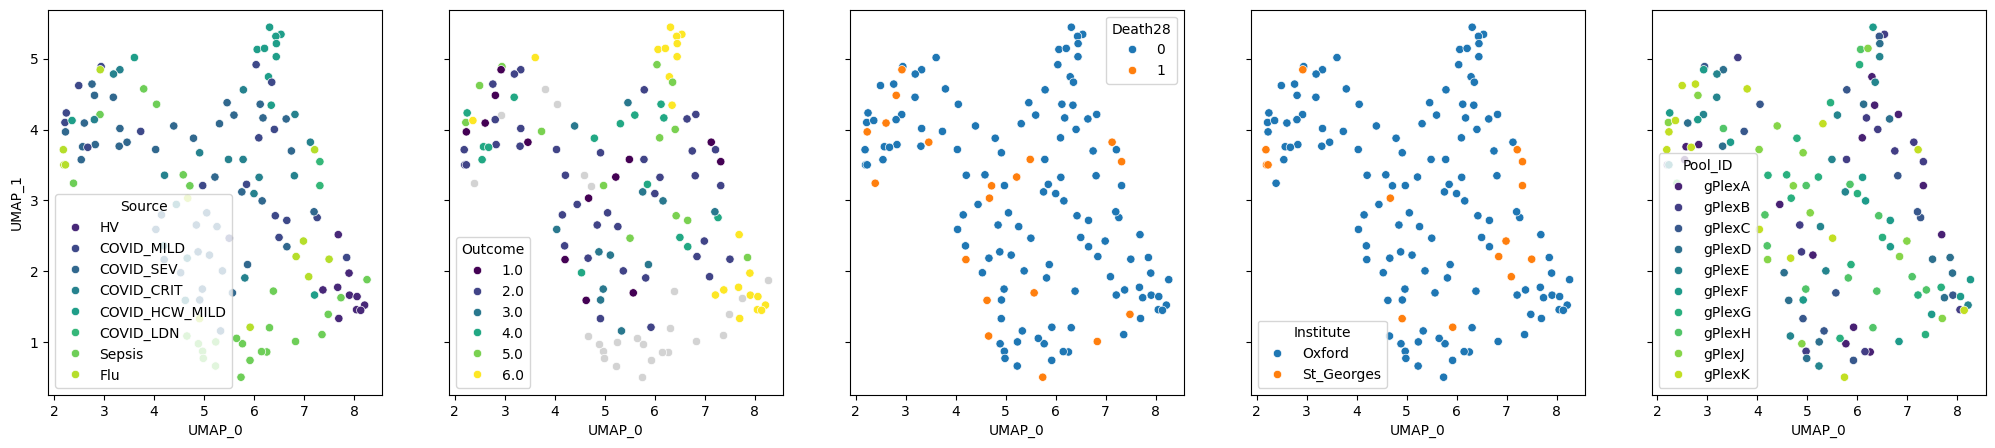

In [18]:
pseudobulk.plot_embedding(method="UMAP", metadata_cols=samples_metadata_cols);

Other dimensionality reduction methods are also available

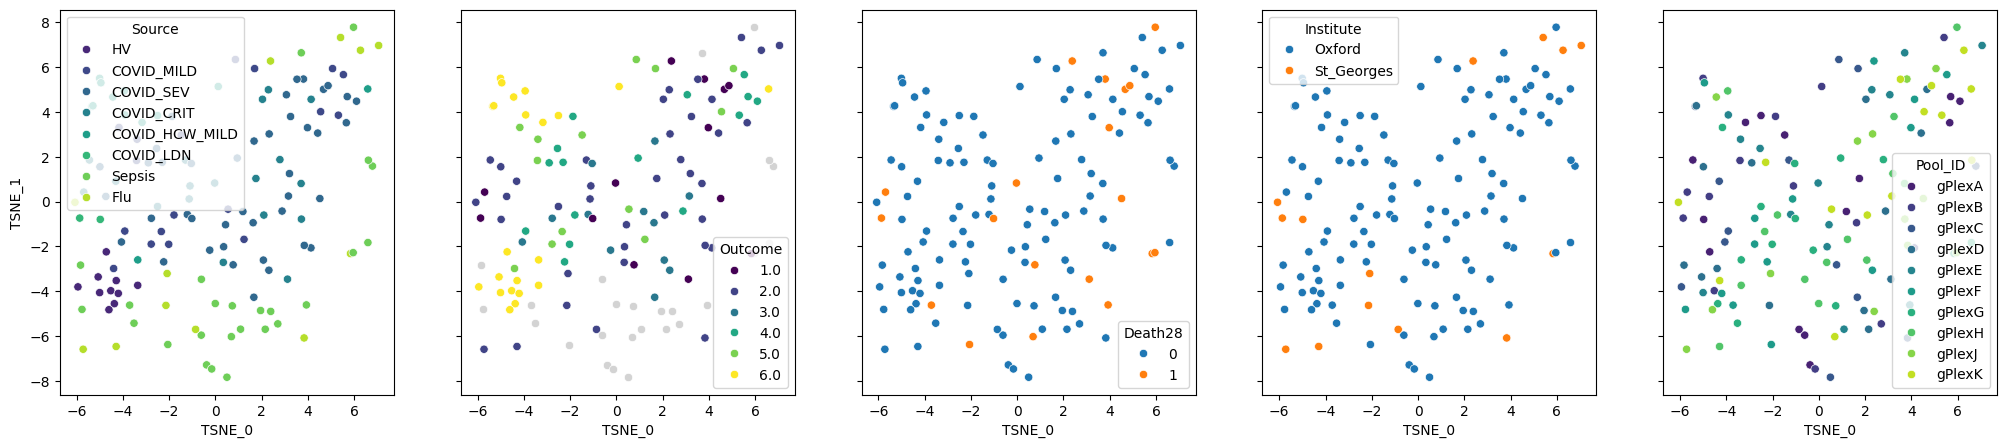

In [19]:
pseudobulk.plot_embedding(method="TSNE", metadata_cols=samples_metadata_cols);

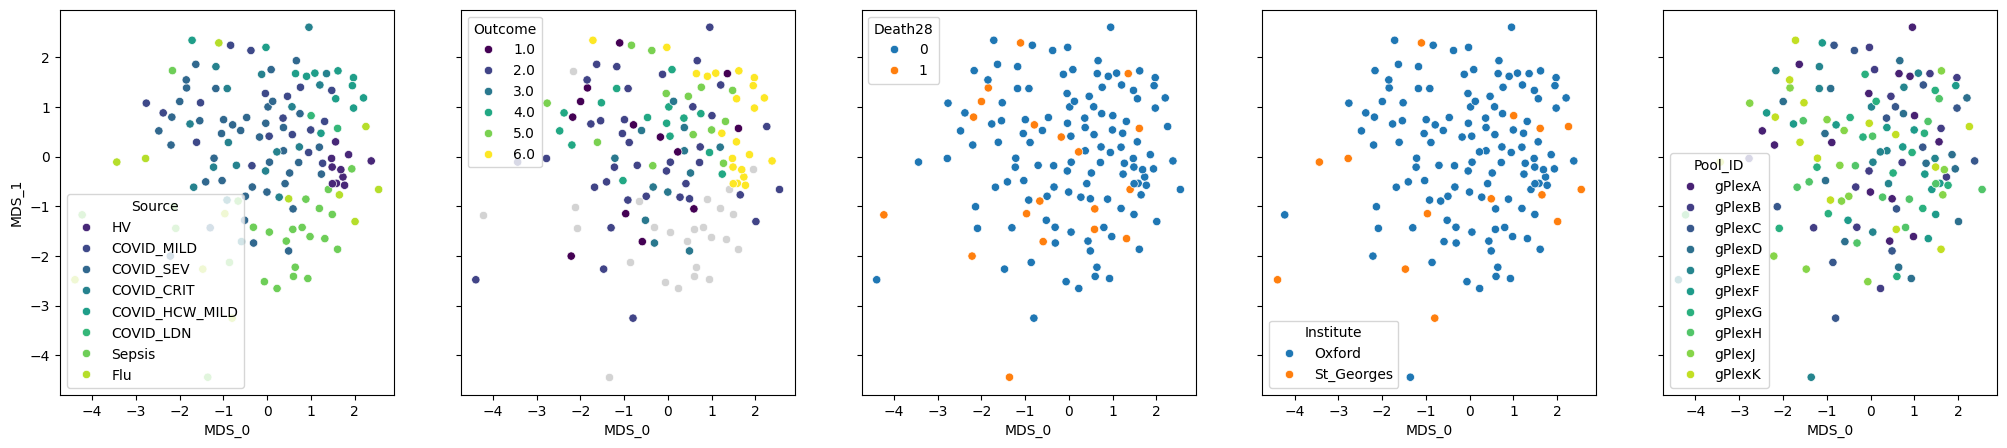

In [20]:
pseudobulk.plot_embedding(method="MDS", metadata_cols=samples_metadata_cols);

### Evaluate how well a covariate is represented

Let's try to classify "Outcome" based on the nearest neighbors for each sample in the representation:

In [21]:
pseudobulk.evaluate_representation(target="Outcome", method="knn", n_neighbors=5, task="classification")

{'score': 0.13977126662840952,
 'metric': 'f1_macro_calibrated',
 'n_unique': 6,
 'n_observations': 113,
 'method': 'knn'}

It doesn't work too good. Now we can try to solve the ranking problem for the same covariate. It will train regressor and use a different metric for evaluation:

In [22]:
pseudobulk.evaluate_representation(target="Outcome", method="knn", n_neighbors=5, task="ranking")

{'score': 0.6103813851943187,
 'metric': 'spearman_r',
 'n_unique': 6,
 'n_observations': 113,
 'method': 'knn'}

Now let's see how well Pool is represented. This is a technical covariate so we don't want score to be high:

In [23]:
pseudobulk.evaluate_representation(target="Pool_ID", method="knn", n_neighbors=5, task="classification")

{'score': 0.13579292359838518,
 'metric': 'f1_macro_calibrated',
 'n_unique': 10,
 'n_observations': 138,
 'method': 'knn'}

Save the distances to adata to use later

In [24]:
adata.uns["pseudobulk_distances"] = distances
adata.uns["pseudobulk_samples"] = pseudobulk.samples
adata.uns["pseudobulk_UMAP"] = pseudobulk.embeddings["UMAP"]

## Run cell type composition representation

This representation is based on cell type composition differences. It is calculated as a difference between cell type proportions in each sample.

In [25]:
composition = pr.tl.CellGroupComposition(sample_key=sample_id_col, cell_group_key=cell_type_key, layer="X_scVI")
composition.prepare_anndata(adata)
composition_distances = composition.calculate_distance_matrix(force=True)

array([<Axes: xlabel='UMAP_0', ylabel='UMAP_1'>,
       <Axes: xlabel='UMAP_0', ylabel='UMAP_1'>,
       <Axes: xlabel='UMAP_0', ylabel='UMAP_1'>,
       <Axes: xlabel='UMAP_0', ylabel='UMAP_1'>,
       <Axes: xlabel='UMAP_0', ylabel='UMAP_1'>], dtype=object)

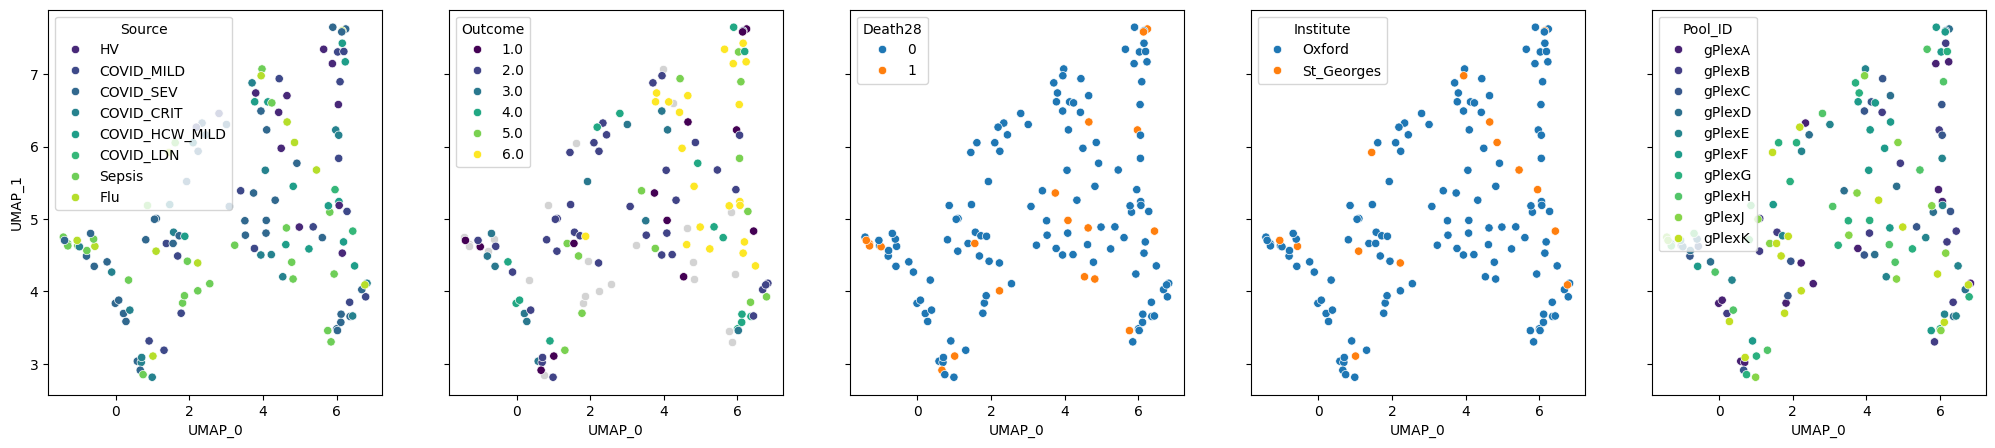

In [26]:
composition.plot_embedding(method="UMAP", metadata_cols=samples_metadata_cols)

We can also visualise cell type proportions for each sample:

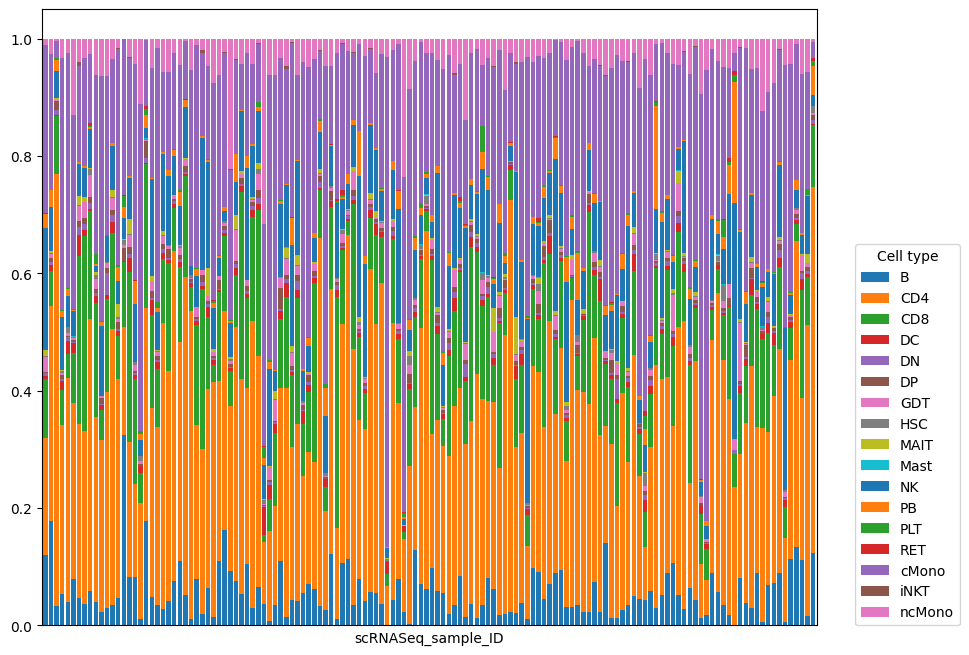

In [27]:
composition.sample_representation.plot(kind="bar", stacked=True, figsize=(10, 8), width=0.8)
plt.xticks([])
plt.legend(loc=(1.05, 0), title="Cell type");

We can see that cell type composition reflects patient outcome worse than pseudobulk:

In [28]:
composition.evaluate_representation(target="Outcome", method="knn", n_neighbors=5, task="ranking")

{'score': 0.4739538892493282,
 'metric': 'spearman_r',
 'n_unique': 6,
 'n_observations': 113,
 'method': 'knn'}

In [29]:
adata.uns["composition_distances"] = composition_distances
adata.uns["composition_samples"] = composition.samples

## Run PILOT representation

[PILOT](https://pubmed.ncbi.nlm.nih.gov/38177382/) is an Optimal Transport-based tool, which calculates distances between samples based on cell type proportion differences taking into account cell type similarities. Note that to run it, you need to install the dependencies additionally:

`pip install patient_representation[pilot]`

In [30]:
pilot = pr.tl.PILOT(
    sample_key=sample_id_col,
    cell_group_key=cell_type_key,
    layer="X_scVI_batch",
    sample_state_col="Outcome",  # It is not used for distances calculation and doesn't really matter
)

In [31]:
pilot.prepare_anndata(adata)

In [32]:
pilot.calculate_distance_matrix()

array([[0.        , 0.14451829, 0.42457524, ..., 0.10953257, 0.21343671,
        0.36804272],
       [0.14451829, 0.        , 0.32280757, ..., 0.10045083, 0.13157015,
        0.25766875],
       [0.42457524, 0.32280757, 0.        , ..., 0.36857701, 0.23438838,
        0.08670158],
       ...,
       [0.10953257, 0.10045083, 0.36857701, ..., 0.        , 0.17271665,
        0.31134621],
       [0.21343671, 0.13157015, 0.23438838, ..., 0.17271665, 0.        ,
        0.21202688],
       [0.36804272, 0.25766875, 0.08670158, ..., 0.31134621, 0.21202688,
        0.        ]])

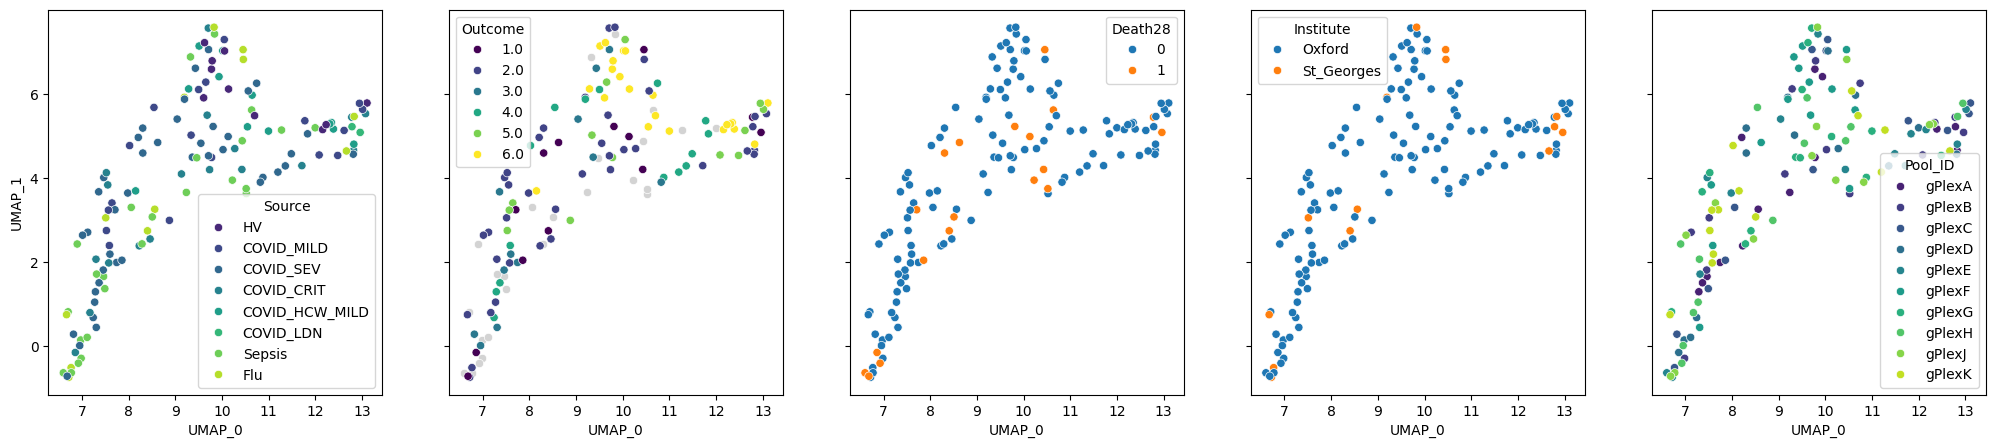

In [33]:
pilot.plot_embedding(method="UMAP", metadata_cols=samples_metadata_cols);

In [34]:
adata.uns["pilot_distances"] = pilot.calculate_distance_matrix()
adata.uns["pilot_samples"] = pilot.samples
adata.uns["pilot_UMAP"] = pilot.embeddings["UMAP"]

Let's check the covariates:

In [35]:
pilot.evaluate_representation(target="Outcome", method="knn", n_neighbors=5, task="ranking")

{'score': 0.48835133146990367,
 'metric': 'spearman_r',
 'n_unique': 6,
 'n_observations': 113,
 'method': 'knn'}

In [36]:
pilot.evaluate_representation(target="Pool_ID", method="knn", n_neighbors=5, task="classification")

{'score': 0.01832203003010072,
 'metric': 'f1_macro_calibrated',
 'n_unique': 10,
 'n_observations': 138,
 'method': 'knn'}

Outcome is represented a bit worse, but Pool ID almost doesn't affect the representation

# Compare representations

Let

In [37]:
def align_representations(adata, meta_adata, samples, methods, cols_of_interest):
    for method in methods:
        #     samples_to_take = np.isin(adata.uns[f"{method}_samples"], samples)
        representation_samples = adata.uns[f"{method}_samples"].tolist()
        samples_order = [representation_samples.index(sample) for sample in samples if sample in representation_samples]

        assert (adata.uns[f"{method}_samples"][samples_order] == samples).all(), "Order of samples is not correct"

        # meta_adata.obsm["umap"] = meta_adata.obsm[f"{method}_UMAP"]
        meta_adata.obsm[f"{method}_distances"] = adata.uns[f"{method}_distances"][samples_order][:, samples_order]

        ep.pp.neighbors(
            meta_adata, use_rep=f"{method}_distances", key_added=f"{method}_neighbors", metric="precomputed"
        )
        ep.tl.leiden(meta_adata, key_added=f"{method}_leiden", neighbors_key=f"{method}_neighbors")

    return meta_adata

In [38]:
combat_methods = [
    "pseudobulk",
    "composition",
    "pilot",
]

In [39]:
combat_samples = list(set(adata.uns[f"{method}_samples"]) for method in combat_methods)
combat_samples = list(set.intersection(*combat_samples))
len(combat_samples)

In [40]:
metadata = metadata.loc[combat_samples]

In [41]:
combat_meta_adata = ep.io.df_to_anndata(metadata)
combat_meta_adata = ep.pp.encode(combat_meta_adata, autodetect=True)
combat_meta_adata

! Features 'Outcome', 'Death28' were detected as categorical features stored numerically.Please verify and correct using `ep.ad.replace_feature_types` if necessary.
! Feature types were inferred and stored in adata.var[feature_type]. Please verify using `ep.ad.feature_type_overview` and adjust if necessary using `ep.ad.replace_feature_types`.


AnnData object with n_obs × n_vars = 138 × 43
    obs: 'Source', 'Institute', 'Pool_ID'
    var: 'feature_type', 'unencoded_var_names', 'encoding_mode'
    layers: 'original'

In [42]:
combat_meta_adata = align_representations(
    adata=adata,
    meta_adata=combat_meta_adata,
    samples=combat_samples,
    methods=combat_methods,
    cols_of_interest=samples_metadata_cols,
)

## Define types and prediction tasks for the covariates

In [43]:
benchmark_schema = {
    "technical": ["Institute", "Pool_ID", "n_cells", "median_QC_ngenes"],
    "clinical": ["Death28", "Outcome", "Source"],
}

cols_with_tasks = {
    "Institute": "classification",
    "Pool_ID": "classification",
    "n_cells": "regression",
    "median_QC_ngenes": "regression",
    "Death28": "classification",
    "Outcome": "ranking",
    "Source": "classification",
}

In [44]:
results = []

for method in combat_methods:
    for covariate_type in benchmark_schema:
        for col in benchmark_schema[covariate_type]:
            task = cols_with_tasks[col]
            try:
                result = pr.tl.evaluate_representation(
                    distances=combat_meta_adata.obsm[f"{method}_distances"],
                    target=metadata[col],
                    method="knn",
                    task=task,
                    #             n_neighbors=5
                )
            except Exception as e:
                print("Method:", method)
                print("Col:", col)
                print("Task:", task)
                print(e)
                print()
                continue
            #             raise(e)
            result["representation"] = method
            result["covariate"] = col
            result["covariate_type"] = covariate_type

            if result["metric"] == "spearman_r":
                result["score"] = abs(result["score"])

            if covariate_type == "technical":
                result["score"] = 1 - result["score"]

            results.append(result)

Scores are ranged from 0 to 1

- For covariates that we defined as technical, 0 means that covariate strongly affects the representation, and 1 means that this covariate is randomly distributed across representation
- For biological and clinical covariates, 0 means that a covariate is not represented well (it is randomly distributed), while 1 means that similar patients have similar values of covariate 

In [45]:
knn_results = pd.DataFrame(results)
knn_results.sort_values("score", ascending=False)

,score,metric,n_unique,n_observations,method,representation,covariate,covariate_type
0,1.000000,f1_macro_calibrated,2,138,knn,pseudobulk,Institute,technical
8,1.000000,f1_macro_calibrated,10,138,knn,composition,Pool_ID,technical
15,1.000000,f1_macro_calibrated,10,138,knn,pilot,Pool_ID,technical
14,1.000000,f1_macro_calibrated,2,138,knn,pilot,Institute,technical
7,0.928846,f1_macro_calibrated,2,138,knn,composition,Institute,technical
1,0.824655,f1_macro_calibrated,10,138,knn,pseudobulk,Pool_ID,technical
9,0.803490,spearman_r,138,138,knn,composition,n_cells,technical
16,0.792614,spearman_r,138,138,knn,pilot,n_cells,technical
10,0.752516,spearman_r,119,138,knn,composition,median_QC_ngenes,technical
17,0.656404,spearman_r,119,138,knn,pilot,median_QC_ngenes,technical


Text(0.5, 1.0, 'KNN-score')

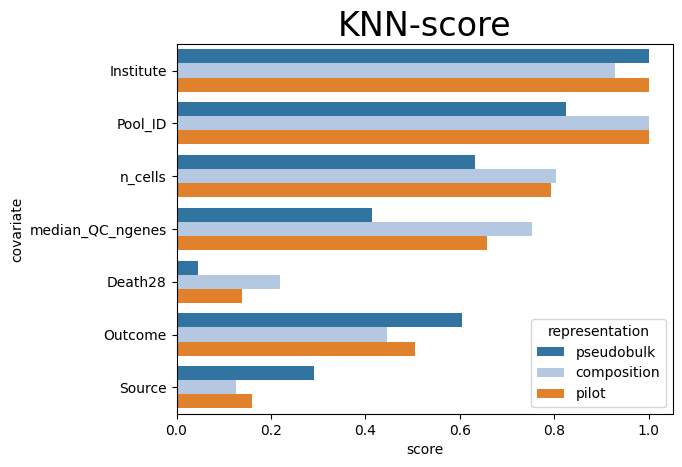

In [46]:
# plt.figure(figsize=(10, 20))
sns.barplot(data=knn_results, y="covariate", x="score", orient="h", hue="representation", palette="tab20")
plt.xlim(0, 1.05)
plt.title("KNN-score", fontsize=24)

In [47]:
knn_results_wide = knn_results.pivot(index="representation", columns="covariate", values="score")
# knn_results_wide.reset_index(inplace=True)

# Order the columns as in benchmark schema
cols_order = ["total"]

for covariate_type in benchmark_schema:
    cols_order.extend(benchmark_schema[covariate_type])
    cols_order.append(covariate_type)

cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#FF9693", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
)

col_defs = []

col_defs.append(
    ColumnDefinition(
        "total",
        width=0.7,
        plot_fn=bar,
        plot_kw={
            "cmap": cmap,
            "plot_bg_bar": True,
            "annotate": True,
            "height": 0.5,
            "lw": 0.5,
            "formatter": lambda x: round(x, 2),
        },
    )
)

for covariate_type in benchmark_schema:
    type_cols = benchmark_schema[covariate_type]

    for col in type_cols:
        col_def = ColumnDefinition(
            name=col,
            width=0.75,
            formatter=lambda x: round(x, 2),
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle", "pad": 0.35},
            },
            cmap=normed_cmap(knn_results["score"], cmap=matplotlib.cm.PiYG, num_stds=2.5),
            group=covariate_type,
        )

        col_defs.append(col_def)

    knn_results_wide[covariate_type] = knn_results_wide[type_cols].mean(axis=1)
    col_defs.append(
        ColumnDefinition(
            covariate_type,
            width=0.7,
            plot_fn=bar,
            plot_kw={
                "cmap": cmap,
                "plot_bg_bar": True,
                "annotate": True,
                "height": 0.5,
                "lw": 0.5,
                "formatter": lambda x: round(x, 2),
            },
        )
    )


#     col_defs.append(type_cols)
clin_weight = 2 / 3

knn_results_wide["total"] = (
    clin_weight * knn_results_wide["clinical"] + (1 - clin_weight) * knn_results_wide["technical"]
)

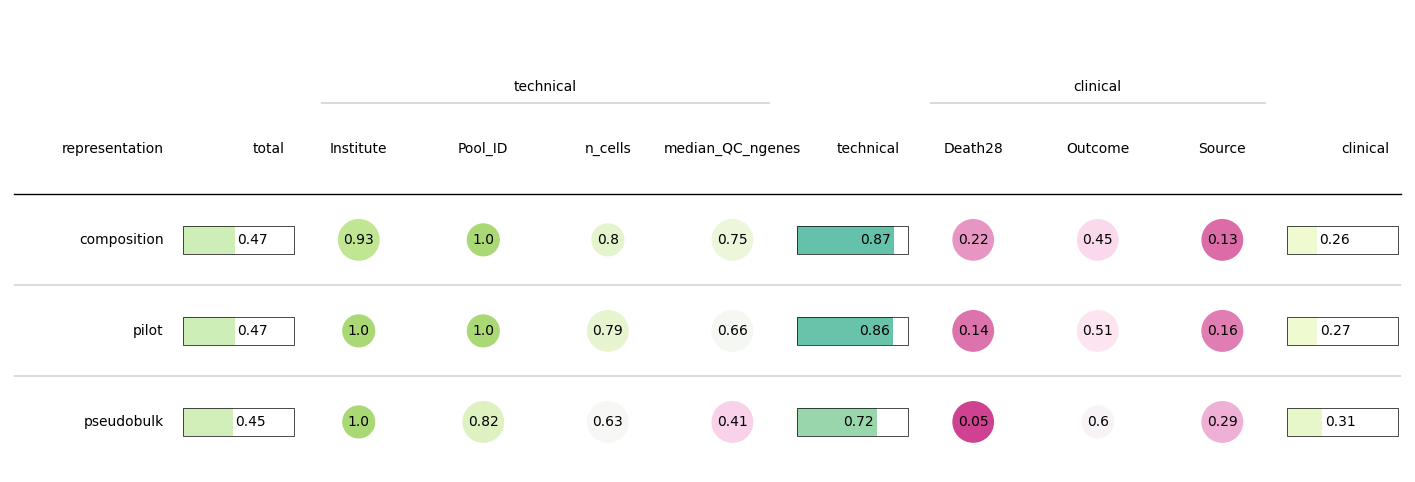

In [48]:
fig, ax = plt.subplots(figsize=(18, 6))

Table(knn_results_wide[cols_order].sort_values("total", ascending=False), column_definitions=tuple(col_defs), ax=ax)

# Other methods

There are other methods implemented that you might want to try:
- Aggregated per cell type (or some other group) pseudobulk: `pr.tl.GroupedPseudobulk`
- Composition differences: `pr.tl.CellGroupComposition`
- scPoli: `pr.tl.SCPoli`
- MrVI: `pr.tl.MrVI`
- PhEMD: `pr.tl.PhEMD`
- MOFA: `pr.tl.MOFA`
- GloScope: `pr.tl.GloScope`

In the [sample representation benchmark](https://github.com/lueckenlab/SPARE/tree/feature/viash_nextflow_pipeline), we found GloScope to be the best representation method. For running it, R installation is required. You can use [environment](https://github.com/lueckenlab/patpy/blob/main/envs/gloscope.yaml) from this repository or manually install required dependencies.